In [7]:
import pandas as pd
import numpy as np
import re
import time
from pymystem3 import Mystem
from tqdm import tqdm
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc


from sklearn.model_selection import train_test_split

# Загрузка размеченного датасета

In [8]:
data = pd.read_csv('data/video_games_01.csv')
data = data.sort_values(by='assessment')
data = data[0:7500]
data.shape

(7500, 2)

In [9]:
data.head(5)

,review,assessment
3737,Игра для титанов духа :) Если у вас: Крепкие н...,0
3864,Необычный интерфейс и персонажи - пожалуй с то...,0
3903,"Осторожно, употребление продукта вредит вашей ...",0
3900,Унылая гриндилка с красивыми артами. Играть не...,0
3915,Игра классная. Такое количество воинов потерял...,0


In [10]:
# Количество позитивных (1) и отрицательных отзывов (0)
data['assessment'].value_counts()

assessment
1    3891
0    3609
Name: count, dtype: int64

In [11]:
# Оставим в тексте только кириллические символы
def clear_text(text):
    clear_text = re.sub(r'[^А-яЁё]+', ' ', text).lower()
    return " ".join(clear_text.split())
    

# напишем функцию удаляющую стоп-слова
def clean_stop_words(text, stopwords):
    text = [word for word in text.split() if word not in stopwords]
    return " ".join(text)

In [12]:
# загрузим список стоп-слов
stopwords = set(nltk_stopwords.words('russian'))
np.array(stopwords)

array({'этом', 'конечно', 'быть', 'ней', 'я', 'этот', 'хорошо', 'с', 'эти', 'надо', 'два', 'ли', 'об', 'на', 'чего', 'всю', 'вас', 'тем', 'к', 'другой', 'моя', 'или', 'сейчас', 'сам', 'ним', 'же', 'том', 'нельзя', 'зачем', 'него', 'вдруг', 'ведь', 'тот', 'а', 'будто', 'эту', 'тогда', 'им', 'но', 'так', 'наконец', 'лучше', 'хоть', 'про', 'нас', 'может', 'под', 'чтобы', 'где', 'три', 'при', 'можно', 'по', 'уже', 'их', 'никогда', 'всегда', 'о', 'теперь', 'она', 'вам', 'себе', 'совсем', 'для', 'этой', 'ничего', 'там', 'даже', 'ей', 'было', 'от', 'был', 'уж', 'была', 'его', 'иногда', 'будет', 'свою', 'между', 'ни', 'этого', 'что', 'со', 'меня', 'ж', 'через', 'чтоб', 'мой', 'того', 'один', 'мы', 'впрочем', 'он', 'еще', 'здесь', 'ты', 'них', 'какая', 'были', 'всего', 'разве', 'нибудь', 'да', 'такой', 'нее', 'после', 'когда', 'потом', 'себя', 'во', 'есть', 'если', 'тоже', 'бы', 'в', 'не', 'без', 'они', 'какой', 'только', 'кто', 'чем', 'потому', 'как', 'почти', 'за', 'тут', 'перед', 'вот', 'вы'

In [13]:
# Протестируем работу функции очистки текста
review = data['review'][np.random.randint(data.shape[0])]
print(review)
print('=======================================')
print(clean_stop_words((clear_text(review)), stopwords))

Как же я не на вижу эту игру, но люблю
вижу игру люблю


In [14]:
# Очистим тексты отзывов
start_clean = time.time()

data['review_clear'] = data['review']\
     .apply(lambda x: clean_stop_words(clear_text(str(x)), stopwords))

print('Обработка текстов заняла: '+str(round(time.time() - start_clean, 2))+' секунд')

Обработка текстов заняла: 0.12 секунд


In [15]:
data

,review,assessment,review_clear
3737,Игра для титанов духа :) Если у вас: Крепкие н...,0,игра титанов духа крепкие нервы стальные яйца ...
3864,Необычный интерфейс и персонажи - пожалуй с то...,0,необычный интерфейс персонажи пожалуй точки зр...
3903,"Осторожно, употребление продукта вредит вашей ...",0,осторожно употребление продукта вредит вашей н...
3900,Унылая гриндилка с красивыми артами. Играть не...,0,унылая гриндилка красивыми артами играть интер...
3915,Игра классная. Такое количество воинов потерял...,0,игра классная такое количество воинов потерял ...
...,...,...,...
7474,"Игра прикольная , в этой игре можно почувствов...",1,игра прикольная игре почувствовать джамшутом
7473,"Симулятор по созданию своего ,идеального дома!",1,симулятор созданию своего идеального дома
7472,классная игра и постоянно обновляется),1,классная игра постоянно обновляется
7503,Просто игра для рилакса. Чего ещё надо?,1,просто игра рилакса ещё


In [16]:
data_clear = data[['review_clear', 'assessment']]
data_clear.head()

,review_clear,assessment
3737,игра титанов духа крепкие нервы стальные яйца ...,0
3864,необычный интерфейс персонажи пожалуй точки зр...,0
3903,осторожно употребление продукта вредит вашей н...,0
3900,унылая гриндилка красивыми артами играть интер...,0
3915,игра классная такое количество воинов потерял ...,0


# Лемматизация отзывов

In [17]:
def lemmatize(df : (pd.Series, pd.DataFrame),
              text_column : (None, str),
              n_samples : int,
              break_str = 'br',
             ) -> pd.Series:
    
    result = []
    
    m = Mystem()    
    
    for i in tqdm(range((df.shape[0] // n_samples) + 1)) :
        
        start = i * n_samples
        
        stop = start + n_samples
        
        sample = break_str.join(df[text_column][start : stop].values)
        
        lemmas = m.lemmatize(sample)
        
        lemm_sample = ''.join(lemmas).split(break_str)
        
        result += lemm_sample
        
    return pd.Series(result, index = df.index)

In [18]:
data['lemm_clean_review'] = lemmatize(
    df = data,
    text_column = 'review_clear',
    n_samples = 100,
    break_str = 'br',
    )

100%|██████████| 76/76 [01:03<00:00,  1.20it/s]


In [19]:
data.head()

,review,assessment,review_clear,lemm_clean_review
3737,Игра для титанов духа :) Если у вас: Крепкие н...,0,игра титанов духа крепкие нервы стальные яйца ...,игра титан дух крепкий нерв стальной яйцо огне...
3864,Необычный интерфейс и персонажи - пожалуй с то...,0,необычный интерфейс персонажи пожалуй точки зр...,необычный интерфейс персонаж пожалуй точка зре...
3903,"Осторожно, употребление продукта вредит вашей ...",0,осторожно употребление продукта вредит вашей н...,осторожно употребление продукт вредить ваш нер...
3900,Унылая гриндилка с красивыми артами. Играть не...,0,унылая гриндилка красивыми артами играть интер...,унылая гриндилка красивый арта играть интересн...
3915,Игра классная. Такое количество воинов потерял...,0,игра классная такое количество воинов потерял ...,игра классный такой количество воин потерять с...


# Получение TF-IDF векторных представлений размеченных отзывов

In [20]:
train, test = train_test_split(data, test_size = 0.2, random_state = 6)

print(train.shape)
print(test.shape)

(6000, 4)
(1500, 4)


In [21]:
train.head()

,review,assessment,review_clear,lemm_clean_review
16328,"переборщили с реализмом, превратив игру в неиг...",0,переборщили реализмом превратив игру неиграбел...,отыгрыш пердак вымышленный технике
4185,Отправил козляток на верную смертб.,1,отправил козляток верную смертб,мрак всюду мрак спасения
20343,"Игра была очень смешной, насыщенной, весёлой. ...",0,игра очень смешной насыщенной весёлой мёртвая,поиграл понимать прикол кривой стрельба жепы
16161,"Игра не понятная, ужасные режимы, через чур тр...",0,игра понятная ужасные режимы чур требовательна...,точно специальный издание рекомендовать
7115,"Ой, как плохо, ооооочень плохо....",0,ой плохо ооооочень плохо,игра полноеее г работать стобильно


In [22]:
# Сравним распределение целевого признака в выборках (распределение положительных отзывов)
for sample in [train, test]:    
    print(sample[sample['assessment'] == 1].shape[0] / sample.shape[0])

0.52
0.514


In [23]:
# Получим векторные представления текстов
count_idf_1 = TfidfVectorizer(ngram_range=(1,1))

In [24]:
tf_idf_base_1 = count_idf_1.fit(data['review_clear'])
tf_idf_train_base_1 = count_idf_1.transform(train['review_clear'])
tf_idf_test_base_1 = count_idf_1.transform(test['review_clear'])

In [25]:
display(tf_idf_test_base_1.shape)
display(tf_idf_train_base_1.shape)

(1500, 28706)

(6000, 28706)

In [26]:
logreg_model_base_1 = LogisticRegression(solver = 'lbfgs',
                                    random_state = 6,
                                    max_iter= 10000,
                                    n_jobs= -1)

Получим прогноз и оценим качество модели

In [27]:
logreg_model_base_1.fit(tf_idf_train_base_1, train['assessment'])

LogisticRegression(max_iter=10000, n_jobs=-1, random_state=6)

In [28]:
predict_lr_base_proba = logreg_model_base_1.predict_proba(tf_idf_test_base_1)

# Предварительное обучение моделей

In [29]:
count_idf_lemm = TfidfVectorizer(ngram_range=(1,1))

In [30]:
tf_idf_lemm = count_idf_lemm.fit(data['lemm_clean_review'])
tf_idf_train_lemm = count_idf_lemm.transform(train['lemm_clean_review'])
tf_idf_test_lemm = count_idf_lemm.transform(test['lemm_clean_review'])

In [31]:
display(tf_idf_train_lemm.shape)
display(tf_idf_test_lemm.shape)

(6000, 18081)

(1500, 18081)

In [32]:
model_lr_lemm = LogisticRegression(solver = 'lbfgs',
                                    random_state = 6,
                                    max_iter= 10000,
                                    n_jobs= -1)

In [33]:
model_lr_lemm.fit(tf_idf_train_lemm, train['assessment'])

LogisticRegression(max_iter=10000, n_jobs=-1, random_state=6)

In [34]:
predict_lr_lemm_proba = model_lr_lemm.predict_proba(tf_idf_test_lemm)

Сравним с классификатором, который выбирает случайное число от 0 до 1

In [35]:
def coin_classifier(X:np.array) -> np.array:
    predict = np.random.uniform(0.0, 1.0, X.shape[0])
    return predict

In [36]:
coin_predict = coin_classifier(tf_idf_test_base_1)

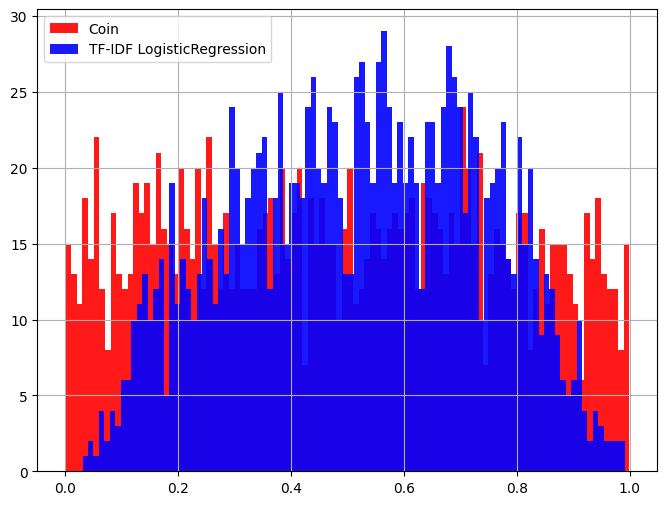

In [37]:
fif = plt.figure(figsize = (8, 6))

pd.Series(coin_predict)\
                .hist(bins = 100,
                      alpha = 0.9,
                      color = 'r',
                      label = 'Coin'
                     )

pd.Series(predict_lr_base_proba[:, 1])\
                .hist(bins = 100,
                      alpha = 0.9,
                      color = 'b',
                      label = 'TF-IDF LogisticRegression'
                     )
plt.legend()   
plt.show()

# Визуализация ROC-кривых классификаторов и матрицы ошибок

In [38]:
fpr_base, tpr_base, _ = roc_curve(test['assessment'], predict_lr_base_proba[:, 1])
roc_auc_base = auc(fpr_base, tpr_base)

In [39]:
fpr_lemm, tpr_lemm, _ = roc_curve(test['assessment'], predict_lr_lemm_proba[:, 1])
roc_auc_lemm = auc(fpr_lemm, tpr_lemm)

In [40]:
fpr_coin, tpr_coin, _ = roc_curve(test['assessment'], coin_predict)
roc_auc_coin = auc(fpr_base, tpr_base)

In [41]:
fig = make_subplots(1,1,
                    subplot_titles = ["Receiver operating characteristic"],
                    x_title="False Positive Rate",
                    y_title = "True Positive Rate"
                   )

fig.add_trace(go.Scatter(
    x = fpr_lemm,
    y = tpr_lemm,
    fill = 'tozeroy',
    name = "ROC lemm (area = %0.3f)" % roc_auc_lemm,
    ))

fig.add_trace(go.Scatter(
    x = fpr_base,
    y = tpr_base,
    #fill = 'tozeroy',
    name = "ROC base (area = %0.3f)" % roc_auc_base,
    ))

fig.add_trace(go.Scatter(
    x = fpr_coin,
    y = tpr_coin,
    mode = 'lines',
    line = dict(dash = 'dash'),
    name = 'Coin classifier (area = 0.5)'
    ))


fig.update_layout(
    height = 600,
    width = 800,
    xaxis_showgrid=False,
    xaxis_zeroline=False,
    template = 'plotly_dark',
    font_color = 'rgba(212, 210, 210, 1)'
    )

In [42]:
# Выведем матрицы ошибок
matrix1 = confusion_matrix(test['assessment'],
                 (predict_lr_base_proba[:, 1] > 0.5).astype('float'),
                 normalize='true',
                )
matrix1

array([[0.82578875, 0.17421125],
       [0.10635538, 0.89364462]])

In [43]:
# Выведем матрицы ошибок для лим
matrix2 = confusion_matrix(test['assessment'],
                 (predict_lr_lemm_proba[:, 1] > 0.5).astype('float'),
                 normalize='true',
                )
matrix2

array([[0.78326475, 0.21673525],
       [0.10505837, 0.89494163]])

Красивая матрица ошибок

In [44]:
fig = make_subplots(1,1)

fig.add_trace(go.Heatmap(
     y = [ 'positive', 'negative'],
     x = ['predicted_negative', 'predicted_positive'],
     z = [matrix1[1, :], matrix1[0, :]],
     colorscale = 'PuBu'
))

fig.add_trace(go.Heatmap(
     y = [ 'positive', 'negative'],
     x = ['predicted_negative', 'predicted_positive'],
     z = [matrix1[1, :], matrix1[0, :]],
     colorscale = 'PuBu'
))

fig.add_annotation(x=0, y=0,
            text = "false negative " + str(round(matrix1[1,0], 2)),
            showarrow=False,
            font = dict(color = 'black'),
            yshift=10)

fig.add_annotation(x=1, y=1,
            text = "false positive " + str(round(matrix1[0,1], 2)),
            showarrow=False,
            font = dict(color = 'black'),
            yshift=10)

fig.add_annotation(x=1, y=0,
            text = "true positive " + str(round(matrix1[1,1], 2)),
            showarrow=False,
            font = dict(color = 'white'),
            yshift=10)

fig.add_annotation(x=0, y=1,
            text = "true negative " + str(round(matrix1[0,0], 2)),
            showarrow=False,
            font = dict(color = 'white'),
            yshift=10)


fig.update_layout(height = 500,
                  width = 500,
                  template = 'plotly_dark',
                  font_color = 'rgba(212, 210, 210, 1)',
                 ).show()

# Визуализация важности признаков

In [45]:
weights = pd.DataFrame({'words': count_idf_1.get_feature_names_out(),
                        'weights': logreg_model_base_1.coef_.flatten()})
weights_min = weights.sort_values(by= 'weights')
weights_max = weights.sort_values(by= 'weights', ascending = False)

In [46]:
weights_min = weights_min[:100]
weights_min['weights'] = weights_min['weights'] * -1
weights_min.head()

,words,weights
4768,деньги,3.377736
664,баланса,3.088870
1021,бесплатно,3.074314
22185,сервера,2.929209
28537,юбисофт,2.846653


In [47]:
weights_max = weights_max[:100]
weights_max.head()

,words,weights
15114,отличная,3.425412
2991,всем,2.894836
531,атмосфера,2.831831
21394,рогалик,2.653476
10552,лучшая,2.551745


# Снижение размерности признакового пространства модели

In [48]:
fig = make_subplots(1,1)

fig.add_trace(go.Histogram(
    x = weights.query('weights != 0')['weights'],
    #histnorm = 'probability',
    opacity = 0.5,
    showlegend = False
))

fig.add_trace(go.Histogram(
    x = weights.query('weights > 0.25 or weights < -0.25')['weights'],
    #histnorm = 'probability',
    opacity = 0.5,
    showlegend = False
))

fig.update_layout(
    height = 600,
    width = 800,
    xaxis_showgrid=False,
    xaxis_zeroline=False,
    template = 'plotly_dark',
    font_color = 'rgba(212, 210, 210, 1)'
    
)

In [49]:
vocab = weights.query('weights > 0.12 or weights < -0.12')['words']
vocab

0                аа
1               ааа
3             ааааа
6         ааааааааа
10       аааааарррр
            ...    
28692            ёб
28693        ёбаная
28696       ёбисофт
28700           ёко
28704          ёпта
Name: words, Length: 8300, dtype: object

In [50]:
count_idf = TfidfVectorizer(vocabulary=vocab, ngram_range=(1,1))

In [51]:
tf_idf_train = count_idf.fit_transform(train['review'])
tf_idf_test = count_idf.transform(test['review'])

In [52]:
display(tf_idf_test.shape)
display(tf_idf_train.shape)

(1500, 8300)

(6000, 8300)

In [53]:
model_lr_base = LogisticRegression(solver = 'lbfgs',
                                    random_state = 6,
                                    max_iter= 10000,
                                    n_jobs= -1)

Получим прогноз и оценим качество модели

In [54]:
model_lr_base.fit(tf_idf_train, train['assessment'])

LogisticRegression(max_iter=10000, n_jobs=-1, random_state=6)

In [55]:
predict_lr_base_proba_1 = model_lr_base.predict_proba(tf_idf_test)

In [56]:
fpr_base_1, tpr_base_1, _ = roc_curve(test['assessment'], predict_lr_base_proba_1[:, 1])
roc_auc_base_1 = auc(fpr_base_1, tpr_base_1)

In [57]:
fig = make_subplots(1,1,
                    subplot_titles = ["Receiver operating characteristic"],
                    x_title="False Positive Rate",
                    y_title = "True Positive Rate"
                   )

fig.add_trace(go.Scatter(
    x = fpr_base,
    y = tpr_base,
    fill = 'tozeroy',
    name = "ROC curve (area = %0.3f)" % roc_auc_base,
    ))

fig.add_trace(go.Scatter(
    x = fpr_base_1,
    y = tpr_base_1,
    fill = 'tozeroy',
    name = "Less dimensity ROC curve (area = %0.3f)" % roc_auc_base_1,
    ))

fig.add_trace(go.Scatter(
    x = fpr_coin,
    y = tpr_coin,
    mode = 'lines',
    line = dict(dash = 'dash'),
    name = 'Coin classifier'
    ))


fig.update_layout(
    height = 600,
    width = 800,
    xaxis_showgrid=False,
    xaxis_zeroline=False,
    template = 'plotly_dark',
    font_color = 'rgba(212, 210, 210, 1)'
    )

Вывод:
Мы снизили размерность векторов tf-idf потеряв при этом 0.4% качества (площадь под ROC кривой при размерности > 25К 0.930, площадь под ROC кривой при размерности > 8K -- 0.926)

# Подбор оптимального порогового значения классификации

In [58]:
scores = {}

weight = 0.55

for threshold in np.linspace(0, 1, 100):
    
    matrix = confusion_matrix(test['assessment'],
                 (predict_lr_base_proba[:, 0] <  threshold).astype('float'),
                 normalize='true',
                )

    score = matrix[0,0] * weight + matrix[1,1] * (1 - weight)
    
    scores[threshold] = score

In [59]:
pd.DataFrame({'true_score':scores.values(),
             'threshold':scores.keys()},
             ).sort_values(by = 'true_score', ascending = False).head()

,true_score,threshold
46,0.866587,0.464646
47,0.863270,0.474747
44,0.861732,0.444444
45,0.860266,0.454545
48,0.859299,0.484848


In [60]:
matrix = confusion_matrix(test['assessment'],
                 (predict_lr_base_proba[:, 0] <  0.464646).astype('int'),
                 normalize='true',
                )
matrix

array([[0.88477366, 0.11522634],
       [0.15564202, 0.84435798]])